#Evaluation of Multiple Algorithmic Trading Strategies for a single equity (LUV).  

The code below is a collection of strategies against the ticker (LUV) or Southwest airlines.  Any equity can be substituted.

Algorithm is a set of operations to be performed in a certain sequence to achieve a certain goal.  

Most are focused on "alpha generating strategies" or the difference between the strategy and benchmark (single stock, SPY, etc.), excess returns of strategy over benchmark.  




Simple Moving AveragesThe first type of trading strategy relies on simple moving averages (SMAs) to generate trading signals and market positionings. These trading strategies have been popularized by so-called technical analysts or chartists. The basic idea is that a shorter-term SMA being higher in value than a longer term SMA signals a long market position and the opposite scenario signals a neutral or short market position

Momentum
The basic idea behind momentum strategies is that a financial instrument is assumed to perform in accordance with its recent performance for some additional time. For example, when a stock index has seen a negative return on average over the last five days, it is assumed that its performance will be negative tomorrow, as well.

Mean Reversion
In mean-reversion strategies, a financial instrument is assumed to revert to some mean or trend level if it is currently far enough away from such a level. For example, assume that a stock trades 10 USD under its 200 days SMA level of 100. It is then expected that the stock price will return to its SMA level sometime soon.

In [ ]:
import pandas as pd
import keras
import pandas.plotting
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [ ]:
from pylab import mpl, plt
plt.style.use('seaborn')

In [ ]:
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3MB 4.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=d3c08870eb0d9bc0ee04d1f432142fa9a2e838609aec296416fa5b86b3a7884e
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
#Defines the ticker symbols and dates to pull data for
symbols = ['LUV']
start = '2015-01-01'
end = '2021-06-03'

In [ ]:
#create the DF and pull in only the Adjusted Close for specified ticker
df = pd.DataFrame()
for s in symbols:
    df[s] = yf.download(s,start,end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Column does not have a name, so name it
df.rename(columns={ df.columns[0] : 'Adj Close'}, inplace=True)

Turtle Trading - Turtle Trading was an experiment in the 1980s and is a basic approach.  Turtle trading: Unlike the two other implementations, this momentum strategy doesn't use any moving average but relies on having a number of specific days, which are high and low.

In [ ]:
#Copying dataframe to implement turtle strategy
df_turtle= df.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df_turtle) * 0.1))
signals = pd.DataFrame(index=df_turtle.index)
signals['signal'] = 0.0
signals['trend'] = df_turtle['Adj Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1


In [ ]:
#Defining the turtle trading strategy
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [ ]:
#Defining the states
states_buy, states_sell, total_gains, invest = buy_stock(df_turtle['Adj Close'], signals['signal'])

day 209: cannot sell anything, inventory 0
day 210: cannot sell anything, inventory 0
day 211: cannot sell anything, inventory 0
day 224: cannot sell anything, inventory 0
day 225: cannot sell anything, inventory 0
day 231: cannot sell anything, inventory 0
day 233: cannot sell anything, inventory 0
day 234: cannot sell anything, inventory 0
day 480: cannot sell anything, inventory 0
day 484: cannot sell anything, inventory 0
day 487: cannot sell anything, inventory 0
day 493: cannot sell anything, inventory 0
day 496: cannot sell anything, inventory 0
day 505: cannot sell anything, inventory 0
day 509: cannot sell anything, inventory 0
day 510: cannot sell anything, inventory 0
day 520: cannot sell anything, inventory 0
day 530: cannot sell anything, inventory 0
day 531: cannot sell anything, inventory 0
day 532: cannot sell anything, inventory 0
day 534: cannot sell anything, inventory 0
day 536: cannot sell anything, inventory 0
day 537: cannot sell anything, inventory 0
day 538: ca

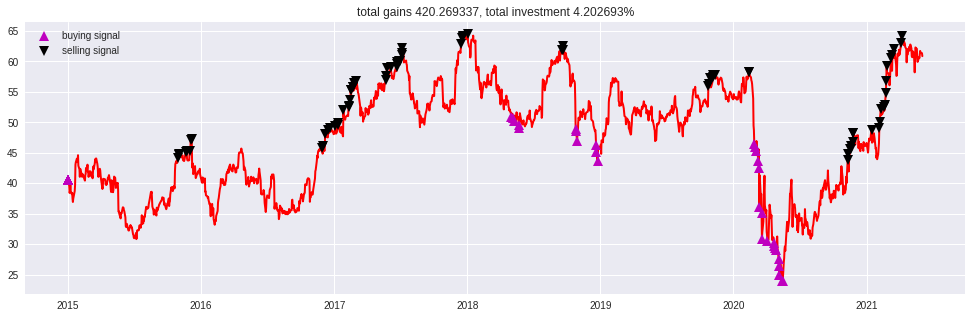

In [ ]:
#Plotting close price
close = df_turtle['Adj Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

Alt Turtle Strategy 

In [ ]:
#Second Turtle Trading Strategy
df_turtle2= df.copy()

In [ ]:
# Defining the strategy
def turtle_trading(financial_data, window_size):
     signals = pd.DataFrame(index=financial_data.index)
     signals['orders'] = 0
     # window_size-days high
     signals['high'] = financial_data['Adj Close'].shift(1).\
         rolling(window=window_size).max()
     # window_size-days low
     signals['low'] = financial_data['Adj Close'].shift(1).\
         rolling(window=window_size).min()
     # window_size-days mean
     signals['avg'] = financial_data['Adj Close'].shift(1).\
         rolling(window=window_size).mean()
         
     signals['long_entry'] = df_turtle2['Adj Close'] > signals.high    
     signals['short_entry'] = df_turtle2['Adj Close'] < signals.low
     signals['long_exit'] = df_turtle2['Adj Close'] < signals.avg
     signals['short_exit'] = df_turtle2['Adj Close'] > signals.avg

     init=True
     position=0
     for k in range(len(signals)):
       if signals['long_entry'][k] and position==0:
             signals.orders.values[k] = 1
             position=1
       elif signals['short_entry'][k] and position==0:
             signals.orders.values[k] = -1
             position=-1
       elif signals['short_exit'][k] and position>0:
             signals.orders.values[k] = -1
             position = 0
       elif signals['long_exit'][k] and position < 0:
             signals.orders.values[k] = 1
             position = 0
       else:
             signals.orders.values[k] = 0
     return signals
ts=turtle_trading(df_turtle2, 50)



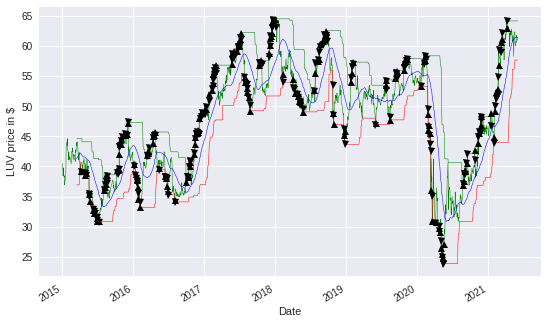

In [ ]:
#Plotting the close price
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='LUV price in $')
df_turtle2["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         df_turtle2["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         df_turtle2["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')

Simple Moving Averages smooth the price trends and remove noise from the series. When asset prices move over their SMA (cross-over), it may indicate a trading signal.  Using a shorter term MA with a longer term MA is known as a "golden cross".  Investors watch for shorter term to cross above the longer term for their buy signal. When the shorter term crosses under the longer term, it's a sell signal.

In [ ]:
# Set the timeframe for the Simple Moving Averages 
SMA1 = 20  
SMA2 = 252

In [ ]:
# Create SMA columns and perform the calculations
df['SMA1'] = df['Adj Close'].rolling(SMA1).mean()  
df['SMA2'] = df['Adj Close'].rolling(SMA2).mean()

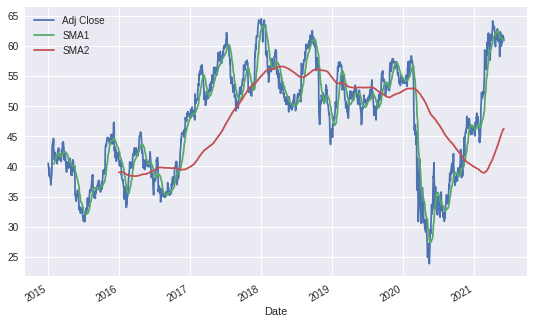

In [ ]:
# Plotting SMA
df.plot()

In [ ]:
#Drop Na's
df.dropna(inplace=True)

In [ ]:
# Define data
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(df['Adj Close'], df['SMA1'], 20)
df.tail()

,Adj Close,SMA1,SMA2,upper_bb,lower_bb
Date,,,,,
2021-05-26,61.209999,60.989000,45.805754,63.236561,58.741438
2021-05-27,61.730000,60.962000,45.921548,63.157129,58.766870
2021-05-28,61.459999,60.896000,46.038055,62.934786,58.857213
2021-06-01,61.349998,60.855999,46.148095,62.821260,58.890739
2021-06-02,60.869999,60.858499,46.252817,62.823694,58.893305


In [ ]:
# Defining strategy
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 1
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(df['Adj Close'], df['lower_bb'], df['upper_bb'])


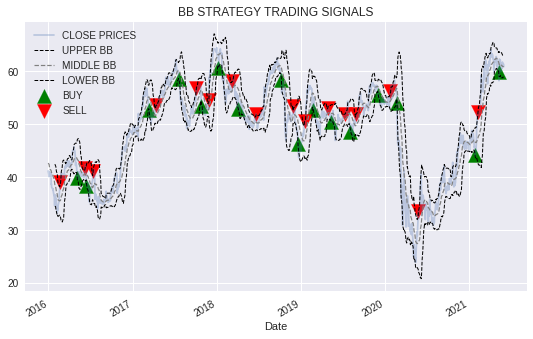

In [ ]:
# Plotting Strategy Trading
df['Adj Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df['SMA1'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# Check where the short term MA is greater than longe term MA, mark those with a 1 and others with -1
df['Position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

In [ ]:
#Viewing Data Frame
df.head()

,Adj Close,SMA1,SMA2,upper_bb,lower_bb,Position
Date,,,,,,
2015-12-31,41.148579,42.626378,39.012639,NaN,NaN,1
2016-01-04,40.097408,42.375126,39.010961,NaN,NaN,1
2016-01-05,40.575222,42.046622,39.015133,NaN,NaN,1
2016-01-06,40.947910,41.728643,39.025229,NaN,NaN,1
2016-01-07,40.087860,41.581001,39.030631,NaN,NaN,1


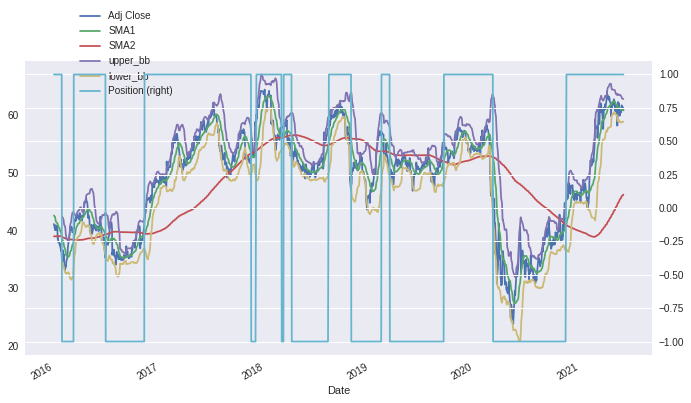

In [ ]:
# Plotting dataframe
ax = df.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Backtest the strategy.  Calculate the logs returns and then multiply by the postion.  Performance values show the return with SMA and holding long.

In [ ]:
# Calculate the log returns for investment (benchmark)
df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [ ]:
#Calculate strategy
df['Strategy'] = df['Position'].shift(1) * df['Returns']

In [ ]:
#Drop NA's
df.dropna(inplace=True)

In [ ]:
# Sum of returns
np.exp(df[['Returns', 'Strategy']].sum())

Returns     1.760086
Strategy    0.360176
dtype: float64

In [ ]:
# Calculate annualized volatility
df[['Returns', 'Strategy']].std() * 252 ** 0.

Returns     0.023025
Strategy    0.023017
dtype: float64

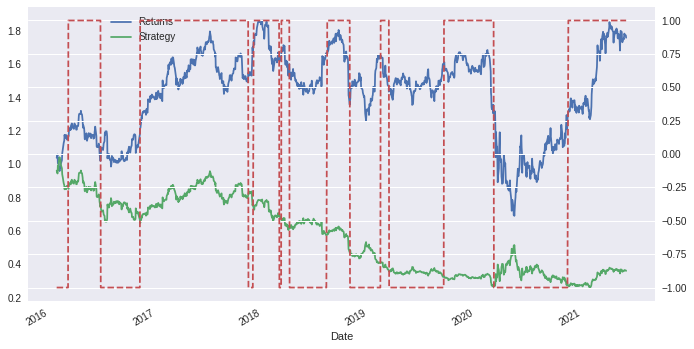

In [ ]:
#Plotting the Strategy
ax = df[['Returns', 'Strategy']].cumsum(
                 ).apply(np.exp).plot(figsize=(10, 6))
df['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Linear OLS Regression using two features, lag 1 and lag 2 (two day and one day lags)


In [ ]:
# Create a copy of the adjusted closing prices in a new dataframe
data2 = df[['Adj Close']].copy()

In [ ]:
# Calculate the log returns
data2['Returns'] = np.log(data2 / data2.shift(1))

In [ ]:
#  Drop Na's
data2.dropna(inplace=True)

In [ ]:
# Viewing DataFrame
data2.head(15)

,Adj Close,Returns
Date,,
2016-02-01,36.609440,0.018175
2016-02-02,34.851120,-0.049221
2016-02-03,35.204689,0.010094
2016-02-04,35.883171,0.019089
2016-02-05,34.105740,-0.050803
2016-02-08,33.178806,-0.027554
2016-02-09,33.685268,0.015149
2016-02-10,33.962399,0.008193
2016-02-11,33.771282,-0.005643


In [ ]:
# Establish direction of movement
data2['Direction'] = np.sign(data2['Returns']).astype(int)

In [ ]:
#Viewing DataFrame Results
data2.head()

,Adj Close,Returns,Direction
Date,,,
2016-02-01,36.609440,0.018175,1
2016-02-02,34.851120,-0.049221,-1
2016-02-03,35.204689,0.010094,1
2016-02-04,35.883171,0.019089,1
2016-02-05,34.105740,-0.050803,-1


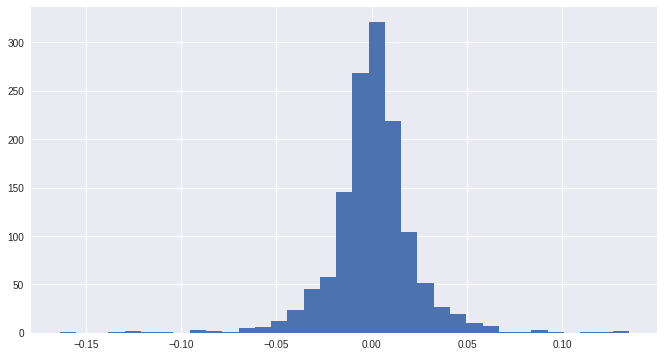

In [ ]:
# Plotting historical returns
data2['Returns'].hist(bins=35, figsize=(10, 6))

In [ ]:
#Setting lags
lags = 2

In [ ]:
# Function to create the lagged values for features
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Returns'].shift(lag)
        cols.append(col)

In [ ]:
# Call function
create_lags(data2)

In [ ]:
# Viewing dataset
data2

,Adj Close,Returns,Direction,lag_1,lag_2
Date,,,,,
2016-02-01,36.609440,0.018175,1,NaN,NaN
2016-02-02,34.851120,-0.049221,-1,0.018175,NaN
2016-02-03,35.204689,0.010094,1,-0.049221,0.018175
2016-02-04,35.883171,0.019089,1,0.010094,-0.049221
2016-02-05,34.105740,-0.050803,-1,0.019089,0.010094
...,...,...,...,...,...
2021-05-26,61.209999,0.010841,1,-0.002145,0.009771
2021-05-27,61.730000,0.008459,1,0.010841,-0.002145
2021-05-28,61.459999,-0.004383,-1,0.008459,0.010841


In [ ]:
#Dropping Na's
data2.dropna(inplace=True)

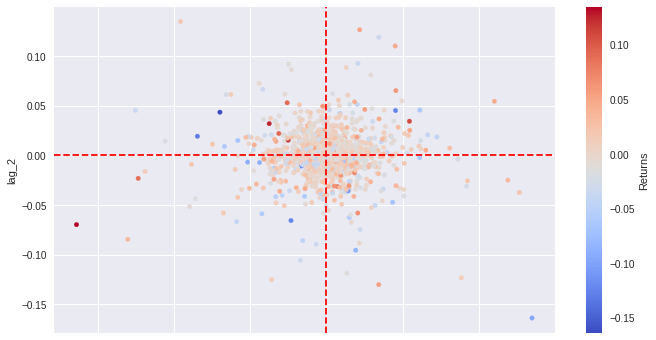

In [ ]:
#Plotting Data Scatter Plot
data2.plot.scatter(x='lag_1', y='lag_2', c='Returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')

In [ ]:
#Imports
from sklearn.linear_model import LinearRegression

In [ ]:
# Use linear regression model to predict movement 
model = LinearRegression()

In [ ]:
#Data Inputs
data2['pos_ols_1'] = model.fit(data2[cols], data2['Returns']).predict(data2[cols])

data2['pos_ols_2'] = model.fit(data2[cols], data2['Direction']).predict(data2[cols])

In [ ]:
#Data Frame
data2.head()

,Adj Close,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2016-02-03,35.204689,0.010094,1,-0.049221,0.018175,0.001856,0.056931
2016-02-04,35.883171,0.019089,1,0.010094,-0.049221,-0.002022,0.042077
2016-02-05,34.105740,-0.050803,-1,0.019089,0.010094,0.000638,0.025416
2016-02-08,33.178806,-0.027554,-1,-0.050803,0.019089,0.001918,0.057511
2016-02-09,33.685268,0.015149,1,-0.027554,-0.050803,-0.001633,0.060697


In [ ]:
# Filtering Data
data2[['pos_ols_1', 'pos_ols_2']] = np.where(
            data2[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [ ]:
# Calculating Data by Multiplying returns by Actual Value
data2['strat_ols_1'] = data2['pos_ols_1'] * data2['Returns']

data2['strat_ols_2'] = data2['pos_ols_2'] * data2['Returns']

In [ ]:
# Viewing Data
data2.head()

,Adj Close,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
Date,,,,,,,,,
2016-02-03,35.204689,0.010094,1,-0.049221,0.018175,1,1,0.010094,0.010094
2016-02-04,35.883171,0.019089,1,0.010094,-0.049221,-1,1,-0.019089,0.019089
2016-02-05,34.105740,-0.050803,-1,0.019089,0.010094,1,1,-0.050803,-0.050803
2016-02-08,33.178806,-0.027554,-1,-0.050803,0.019089,1,1,-0.027554,-0.027554
2016-02-09,33.685268,0.015149,1,-0.027554,-0.050803,-1,1,-0.015149,0.015149


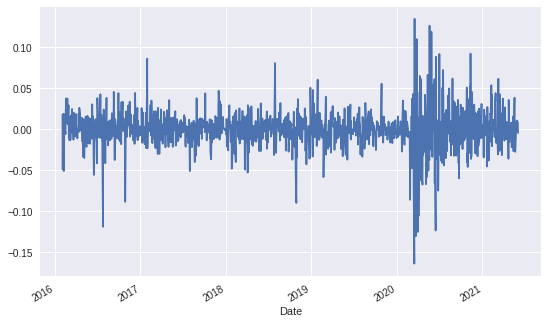

In [ ]:
# Plotting Lag 2 to show behavior
data2['lag_2'].plot()

In [ ]:
#Data Manipulation
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

Returns        1.746572
strat_ols_1    0.839518
strat_ols_2    1.547695
dtype: float64

In [ ]:
# Count number of correct and false predictions by strategy
(data2['Direction'] == data2['pos_ols_1']).value_counts()

False    675
True     667
dtype: int64

In [ ]:
# Calculating True and False
(data2['Direction'] == data2['pos_ols_2']).value_counts()

True     692
False    650
dtype: int64

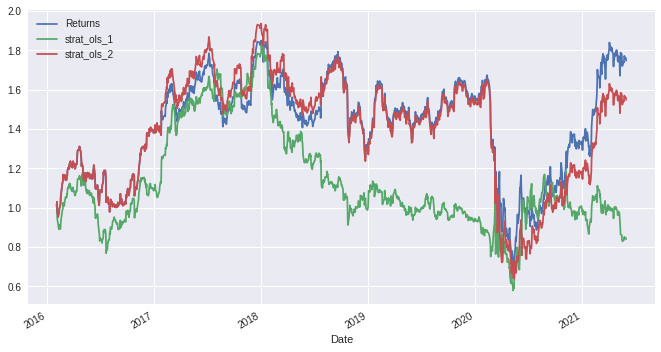

In [ ]:
# Performance over time
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

Facebook Prophet :  The code below is an attempt to use FB prophet for Time Series Forecasting.  (Needs more work and may scrap)

In [ ]:
data3 = df[['Adj Close']].copy()

In [ ]:
data3.reset_index(inplace=True)

In [ ]:
data3

,Date,Adj Close
0,2016-01-29,35.950073
1,2016-02-01,36.609440
2,2016-02-02,34.851120
3,2016-02-03,35.204689
4,2016-02-04,35.883171
...,...,...
1340,2021-05-26,61.209999
1341,2021-05-27,61.730000
1342,2021-05-28,61.459999
1343,2021-06-01,61.349998


In [ ]:
data3 = data3.rename(columns={'Date':'ds', 'Adj Close':'y'})

In [ ]:
data3.shape

(1345, 2)

In [ ]:
df_train = data3[['ds', 'y']].iloc[:2930]
df_predict = data3[['ds']]